<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/07_food_vision_milestone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1 # there is a bug in tensorflow version above 2.4 while using mixed precision

## Check GPU

Google colab offers free GPUs, however not all of them are compatible with mixed precisoion training.

Google colab offers:
* K80
* P100
* Tesla T4

Only Tesla T4 is compatible with mixed precision training 

In [3]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-d5e6f156-474e-e84c-415c-95ea9622e0d2)


In [4]:
# Download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-30 11:08:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-30 11:08:36 (50.5 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [5]:
# Import helper functions 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

 ## Use TensorFlow datasets to download the data

In [6]:
# Import library for tensoflow datasets
import tensorflow_datasets as tfds

In [7]:
# List all available datasets
dataset_list = tfds.list_builders()
print("food101" in dataset_list)

True


In [8]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

## Exploring the Food101 data from tfds

To become one with our data, we want to find:
* Class names
* The shape of the input data(image tensors)
* The datatype
* What the labels looks like (One hot encoded or label encoded)
* Do the labels match up with the class names?

In [9]:
# Feature of food101 dataset from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [10]:
# Get the classnames
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [12]:
 # Output info about our training sample
 for image, label in train_one_sample:
   print(f"""
   image shape: {image.shape}
   image datatype: {image.dtype}
   Target class for fod101: {label}
   Class name: {class_names[label.numpy()]}
   """)


  image shape: (512, 512, 3)
  image datatype: <dtype: 'uint8'>
  Target class for fod101: 75
  Class name: pho
  


In [13]:
# What does our image tensor from tfds looks like
image 

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

In [14]:
# What is the maximum and minimum values
import tensorflow as tf
tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=0>)

## Plot an image from Tensorflow

(-0.5, 511.5, 511.5, -0.5)

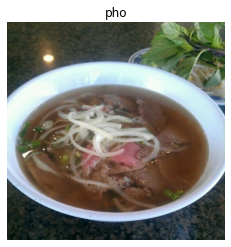

In [15]:
# Plot and image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create a preprocessing function for our data

What we know about our data are:
* Data is in `uint8` type
* Comprised of all different sized tensors
* Not scaled (Pixed values are between 0 and 255)

What models like are:
* Data in `float32` type
* For batches, Tensorflow likes all of the tensors in a batch to be of same size.
* Scaled (between 0 and 1)

As we are going to use EfficientNet, we don't need to rescale the data (This archetecture is having rescaling built-in)

This means our function needs to:
* Reshape all our images to same size.
* Convert the dtype of our tensors from `uint8` to `float32`

In [16]:
# Make function to for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image dtype from 'uint8' to 'float32' and reshapes the images
  to the shape (img_shape, img_shape, color_channels)
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label

## Batch and prepare the dataset

We are now going to make our data input pipeline run really fast.

https://tensorflow.org/guide/data_performance


In [17]:
# Map preprocess function to training data (and parellelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=100).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to testing data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

## Create modelling callbacks 

In [35]:
# Create tensorflow callback (Import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

In [20]:
#!pip install tensorflow==2.4.1

## Setup mixed precision training

Mixed precision ustilizes a combination of float32 and float16 datatypes to speed up model performance

In [23]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla K80, compute capability 3.7
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


## Build feature extraction model

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile our model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")

## Checking layer dtype policies

In [30]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_6 True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


 ## Fit the feature extraction model

In [34]:
history = model.fit(train_data,
                    epochs = 3,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15*len(test_data)),
                    callbacks=[create_tensorboard_callback("training_logs", "EfficientNetB0_food101_full_dataset"),
                               model_checkpoint])

Saving TensorBoard log files to: training_logs/EfficientNetB0_food101_full_dataset/20220130-120924
Epoch 1/3
2368/2368 [==============================] - 380s 147ms/step - loss: 2.3257 - accuracy: 0.4674 - val_loss: 1.2408 - val_accuracy: 0.6751


Epoch 2/3
2368/2368 [==============================] - 329s 139ms/step - loss: 1.3124 - accuracy: 0.6618 - val_loss: 1.1171 - val_accuracy: 0.7010


Epoch 3/3
2368/2368 [==============================] - 332s 140ms/step - loss: 1.1420 - accuracy: 0.7039 - val_loss: 1.0819 - val_accuracy: 0.7071


In [36]:
model.evaluate(test_data)

790/790 [==============================] - 110s 139ms/step - loss: 1.0921 - accuracy: 0.7050


[1.0920754671096802, 0.7049900889396667]